22:01:02 - cmdstanpy - INFO - Chain [1] start processing
22:01:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


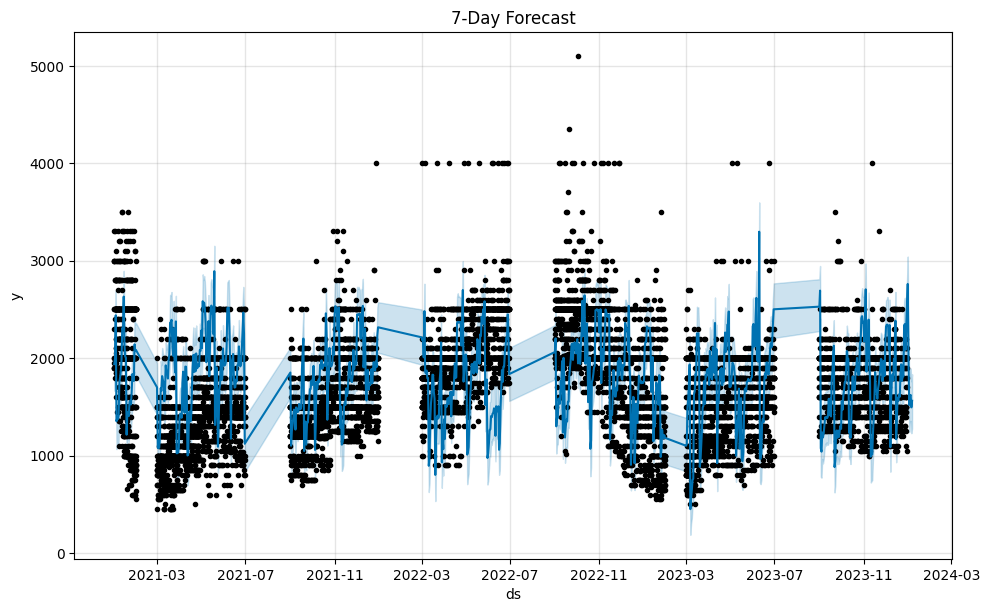

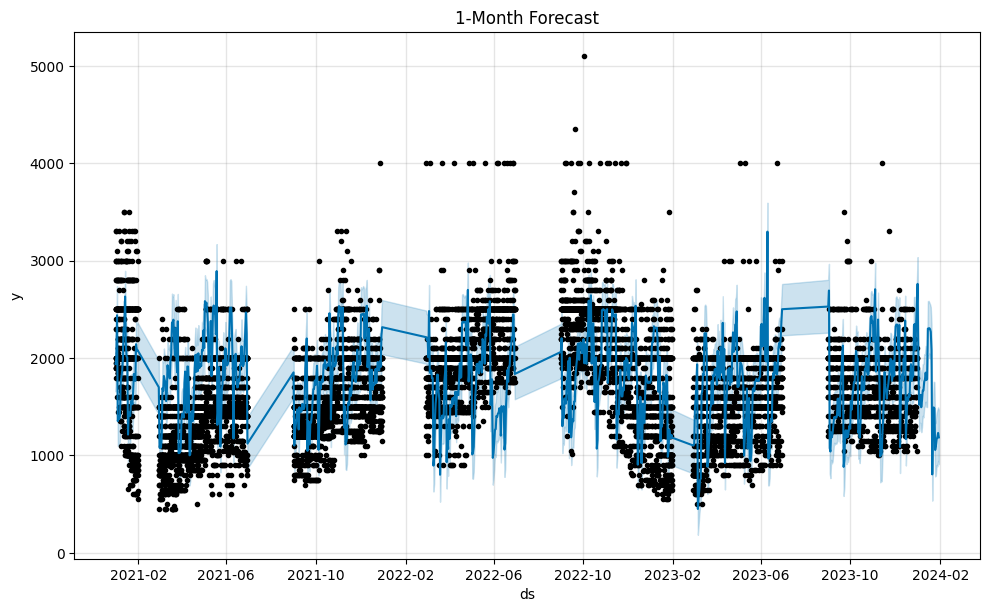

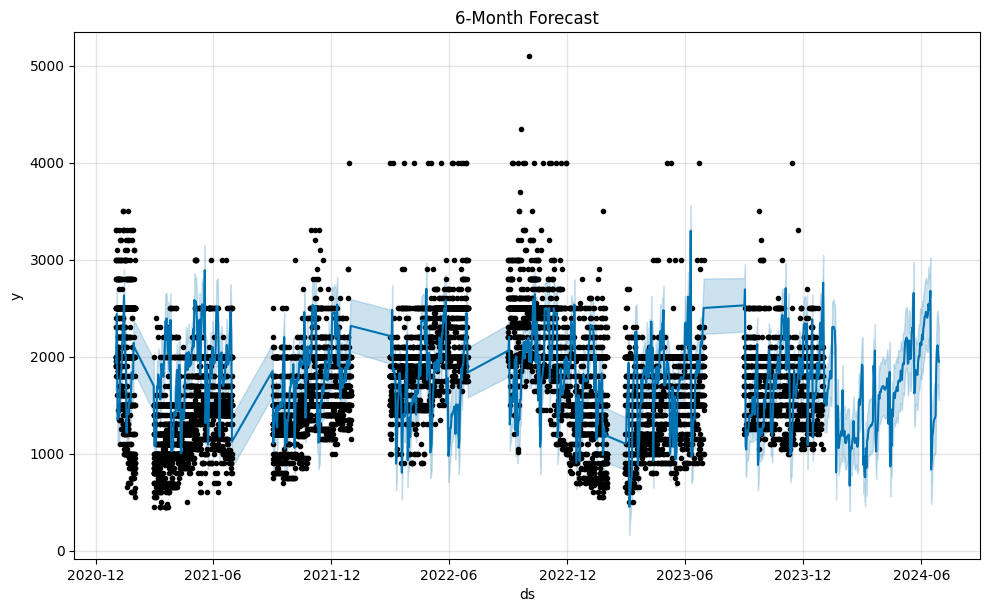

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('engineered_data_final.csv')

# Combine Day, Month, and Year columns to form the 'ds' column
data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

# 'y' column is the target variable (Modal Price)
data['y'] = data['Modal Price (Rs./Quintal)']

# Define the Prophet model
model = Prophet()

# Add external regressors
model.add_regressor('Fertilizer')
model.add_regressor('Petrol Price')
model.add_regressor('Rainfall')
model.add_regressor('Lag_Price')
model.add_regressor('Rolling_Rainfall')

# Fit the model
model.fit(data[['ds', 'y', 'Fertilizer', 'Petrol Price', 'Rainfall', 'Lag_Price', 'Rolling_Rainfall']])

# Specify the number of days for future prediction:
# For 7 days
future_7days = model.make_future_dataframe(periods=7)

# For 1 month (30 days)
future_1month = model.make_future_dataframe(periods=30)

# For 6 months (180 days)
future_6months = model.make_future_dataframe(periods=180)

# Include the regressors in the future dataframe
for future in [future_7days, future_1month, future_6months]:
    future['Fertilizer'] = data['Fertilizer']
    future['Petrol Price'] = data['Petrol Price']
    future['Rainfall'] = data['Rainfall']
    future['Lag_Price'] = data['Lag_Price']
    future['Rolling_Rainfall'] = data['Rolling_Rainfall']

# Predict for 7 days
forecast_7days = model.predict(future_7days)

# Predict for 1 month
forecast_1month = model.predict(future_1month)

# Predict for 6 months
forecast_6months = model.predict(future_6months)

# Plot the forecast for 7 days
model.plot(forecast_7days)
plt.title("7-Day Forecast")
plt.show()

# Plot the forecast for 1 month
model.plot(forecast_1month)
plt.title("1-Month Forecast")
plt.show()

# Plot the forecast for 6 months
model.plot(forecast_6months)
plt.title("6-Month Forecast")
plt.show()


22:33:23 - cmdstanpy - INFO - Chain [1] start processing
22:33:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 250.5183393212907
Mean Squared Error (MSE): 137386.72076121735
Root Mean Squared Error (RMSE): 370.6571471875557


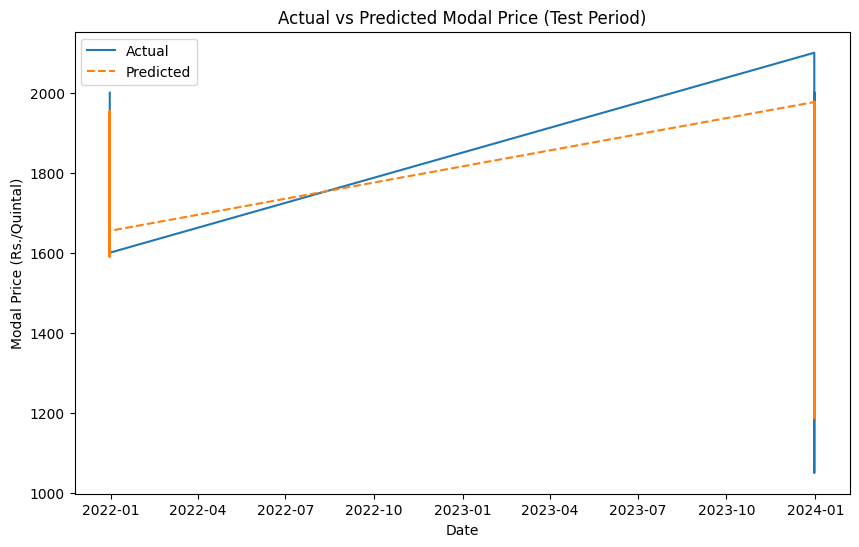

In [11]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load your dataset
data = pd.read_csv('correctly_sorted_data.csv')

# Combine Day, Month, and Year columns to form the 'ds' column
data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

# 'y' column is the target variable (Modal Price)
data['y'] = data['Modal Price (Rs./Quintal)']

# Drop rows with NaN values in relevant columns
data = data.dropna(subset=['ds', 'y', 'Fertilizer', 'Petrol Price', 'Rainfall', 'Lag_Price', 'Rolling_Rainfall'])

# Split the data into training and testing sets
train_data = data.iloc[:-30]  # Use all but the last 30 days for training
test_data = data.iloc[-30:]   # Use the last 30 days for testing

# Define the Prophet model
model = Prophet()

# Add external regressors
model.add_regressor('Fertilizer')
model.add_regressor('Petrol Price')
model.add_regressor('Rainfall')
model.add_regressor('Lag_Price')
model.add_regressor('Rolling_Rainfall')

# Fit the model on training data
model.fit(train_data[['ds', 'y', 'Fertilizer', 'Petrol Price', 'Rainfall', 'Lag_Price', 'Rolling_Rainfall']])

# Create a future dataframe for 30 days into the future
future = model.make_future_dataframe(periods=30)

# Append the correct regressor values for the next 30 days from the test set
future = future.merge(test_data[['ds', 'Fertilizer', 'Petrol Price', 'Rainfall', 'Lag_Price', 'Rolling_Rainfall']], on='ds', how='left')

# Drop rows with NaN values in the future dataframe
future = future.dropna(subset=['Fertilizer', 'Petrol Price', 'Rainfall', 'Lag_Price', 'Rolling_Rainfall'])

# Predict for the test period
forecast = model.predict(future)

# Extract the forecasted values for the test period
forecast_test = forecast[['ds', 'yhat']].iloc[-30:]

# Merge the forecasted values with the actual test data
test_results = test_data[['ds', 'y']].merge(forecast_test, on='ds')

# Calculate accuracy metrics
mae = mean_absolute_error(test_results['y'], test_results['yhat'])
mse = mean_squared_error(test_results['y'], test_results['yhat'])
rmse = np.sqrt(mse)

# Print accuracy metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(test_results['ds'], test_results['y'], label='Actual')
plt.plot(test_results['ds'], test_results['yhat'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.title('Actual vs Predicted Modal Price (Test Period)')
plt.legend()
plt.show()


Mean Absolute Error (MAE): 61.90893333530294
Mean Squared Error (MSE): 17183.213552083387
Root Mean Squared Error (RMSE): 131.08475713096237


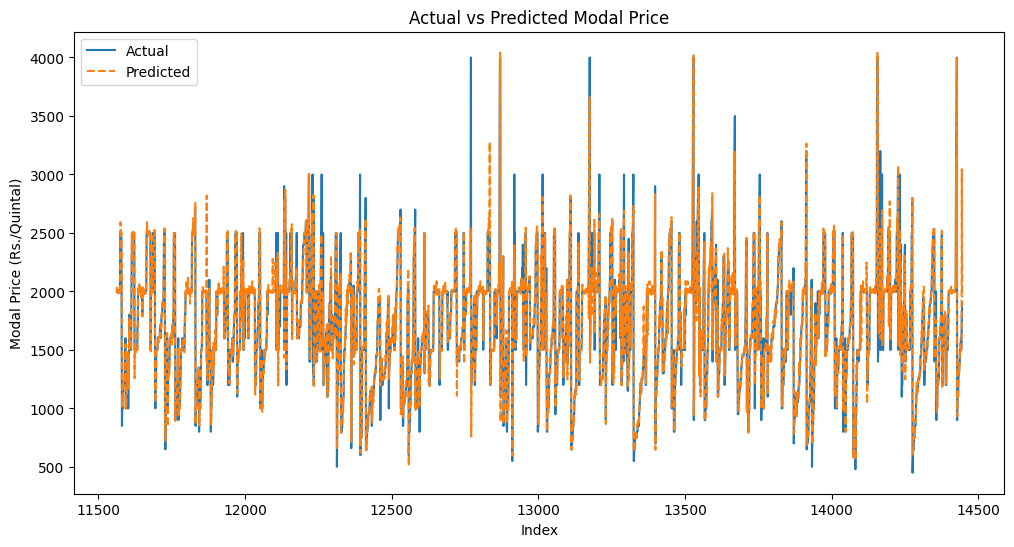

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('engineered_data_final.csv')


data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

data['y'] = data['Modal Price (Rs./Quintal)']

def create_lag_features(df, lags):
    for lag in lags:
        df[f'Lag_{lag}'] = df['y'].shift(lag)
    return df


lags = [1, 7, 30]  


data = create_lag_features(data, lags)

data = data.dropna()

X = data[['ds','Fertilizer', 'Petrol Price','District Name', 'Lag_Price','Rainfall']]
y = data['y']


X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce')

X = X.fillna(0)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


model = XGBRegressor()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.title('Actual vs Predicted Modal Price')
plt.legend()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13780\3795470244.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Mean Absolute Error (MAE): 61.90893333530294
Mean Squared Error (MSE): 17183.213552083387
Root Mean Squared Error (RMSE): 131.08475713096237


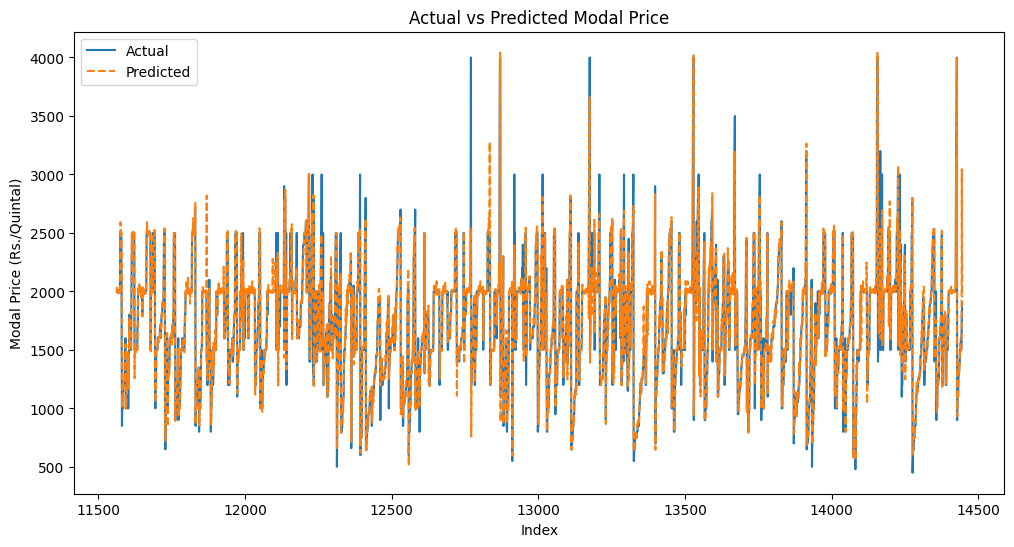

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib  
import matplotlib.pyplot as plt


data = pd.read_csv('engineered_data_final.csv')


data['ds'] = pd.to_datetime(data[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))


data['y'] = data['Modal Price (Rs./Quintal)']


def create_lag_features(df, lags):
    for lag in lags:
        df[f'Lag_{lag}'] = df['y'].shift(lag)
    return df


lags = [1, 7, 30]  


data = create_lag_features(data, lags)


data = data.dropna()


X = data[['ds','Fertilizer', 'Petrol Price','District Name', 'Lag_Price','Rainfall']]
y = data['y']


X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce')

X = X.fillna(0)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


model = XGBRegressor()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


joblib.dump(model, 'potato_model.pkl')

joblib.dump(scaler, 'scaler.pkl')  


plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Modal Price (Rs./Quintal)')
plt.title('Actual vs Predicted Modal Price')
plt.legend()
plt.show()
